In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import glob
import pickle 
import tensorflow as tf 
from IPython.display import display 
pd.options.display.max_columns = None
pd.options.display.max_rows = None
%matplotlib inline
%config  InlineBackend.figure_formats = {'png', 'retina'}
sns.set_style("white")

/Users/MAC/.pyenv/versions/anaconda3-5.0.1/envs/python_ana/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Image file list loading

- using `glob`


In [2]:
pic_img_src = glob.glob('../Dataset/pic_face/*.png')
real_img_src = glob.glob('../Dataset/real_face/*.png')

pic_img_src[1], real_img_src[1]

('../Dataset/pic_face/Screenshot 2018-08-07 20.53.17.png',
 '../Dataset/real_face/backhyun.png')

### Developing tools for image preprocessing 

* `Image`: class 
  > **It holds image information**
  > -  image source as `img_src``
  > -  color image vector as `color_image_vector``
  > -  grayscale image vector as `gray_image_vector``
  > - Its sex information as `sex``

In [3]:
class Image():
    def __init__(self, img_src):
        # type(img_src) == "string"
        self.img_src = img_src
        self.color_image_vector = self.png_to_vector()
        self.gray_image_vector = self.color_to_gray()
        if img_src[-5] == "1":
            #"female"
            self.sex = 1.0
        else :
            #"male"
            self.sex = 0.0
    def __repr__(self):
        return "Image"
    
    def __str__(self):
        return "Image"
            
    def png_to_vector(self):
        image_vector = cv2.imread(self.img_src)
        return image_vector
    def color_to_gray(self):
        gray_image = cv2.cvtColor(self.color_image_vector, cv2.COLOR_BGR2GRAY)
        return gray_image

def image_print(img=None, figsize=(7,7), axis="off", color="RGB"):
    """ when image loaded through openCV, set color on RGB and print it 
    Args:
    img = vectorized image (color, RGB encoded)
    figsize = tuple or list object, it refers figure's size, defalut = (7,7)
    axis = "on", "off", defalut = "off"
    color = "RGB" or "gray", default="RGB"
    Return :
    printing image 
    """
    import numpy 
    if type(img) != numpy.ndarray:
        raise ValueError
#             print("img는 Numpy의 ndarray 이어야 합니다.")
    
    plt.figure(figsize=figsize)
    plt.axis(axis)
    if color == "RGB":
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else :
        plt.imshow(img, cmap='gray')
    plt.show()
    return None

def resizing_image(img, size=(300, 300), interpolation=cv2.INTER_CUBIC):
    """resizing image size (cv2 has to be imported)
    Args :
    img = vectorized image (color, RGB encoded)
    size = tuple or list, size of output image, default=(300, 300)
    interpolation = how to interpolate, cv2's interpolation, default=cv2.INTER_CUBIC
    
    Return :
    resized image vector
    """
    img = cv2.resize(img, dsize=size, interpolation=cv2.INTER_CUBIC)
    return img


### Image resizing and converting to grayscale 


 - Pictogram images have many 0 values, I think it would be harmful, when `the reverse generator`, which is annotated as **F** in the paper, makes real images from pictogram images
 
 > * Solution 
 >   - adding `10`
 >   - the max value is kept with `255`

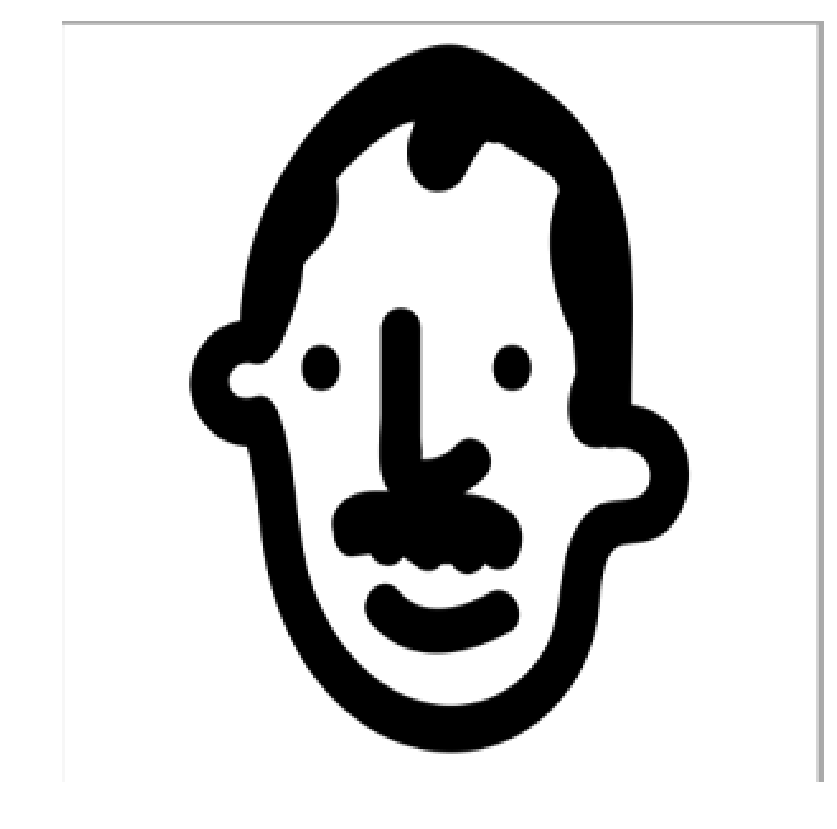

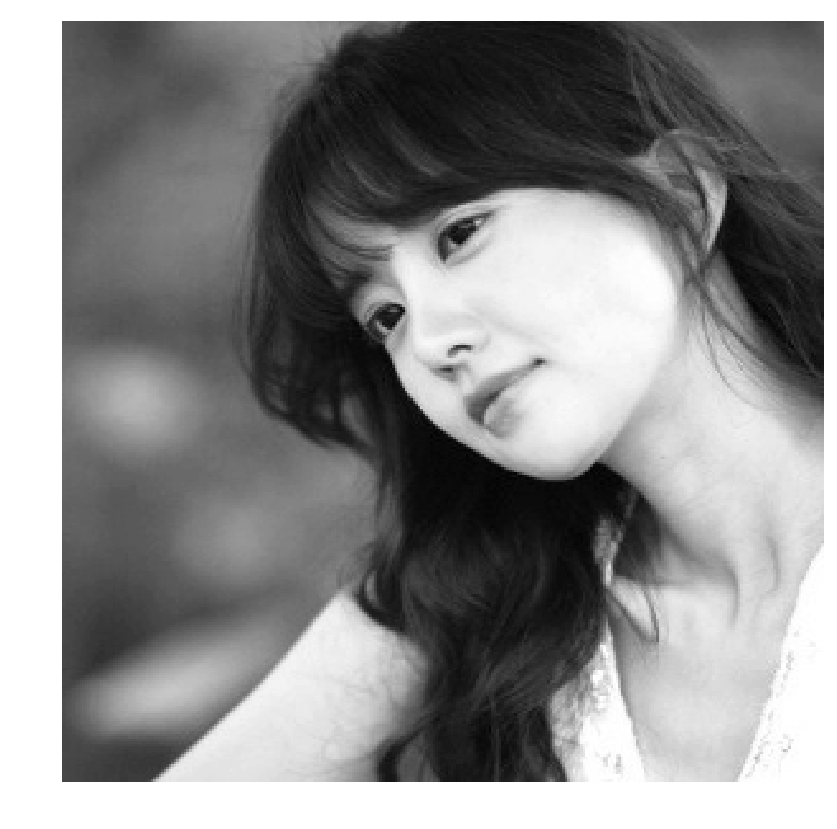

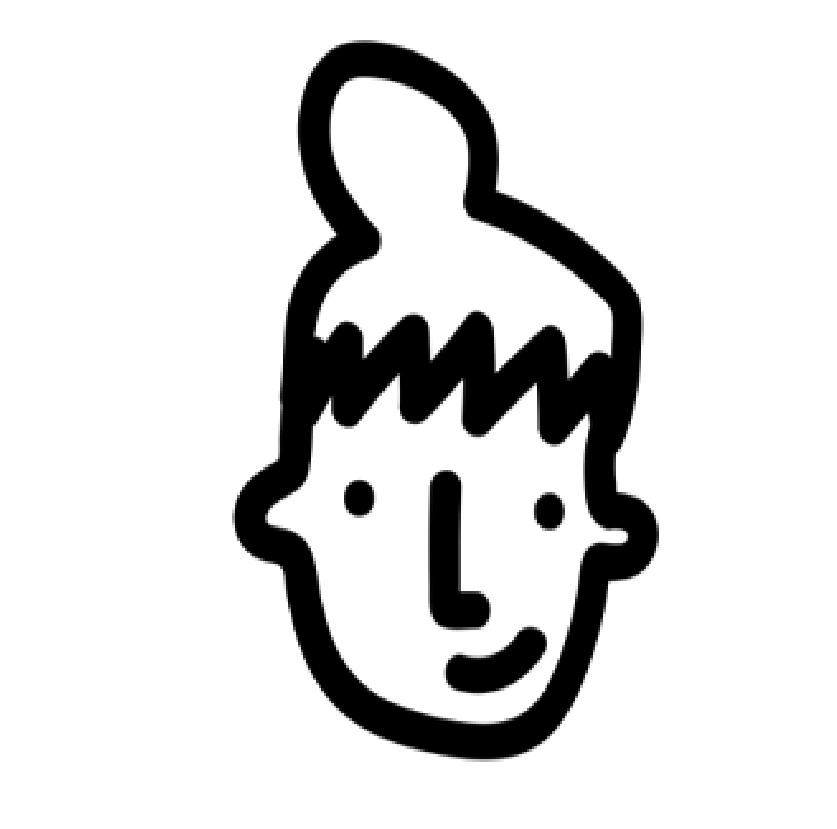

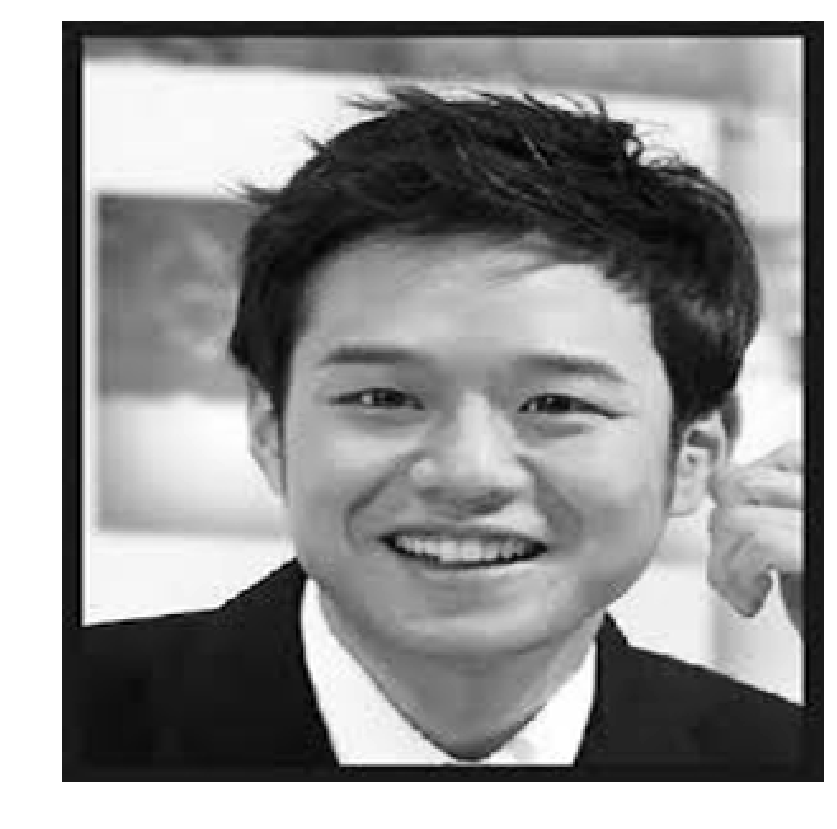

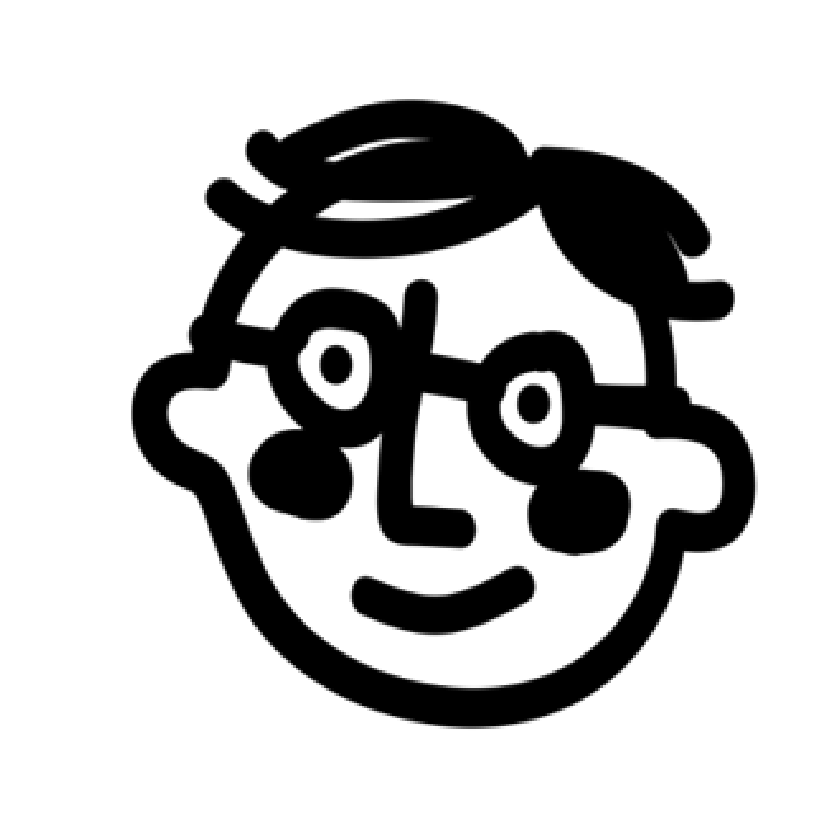

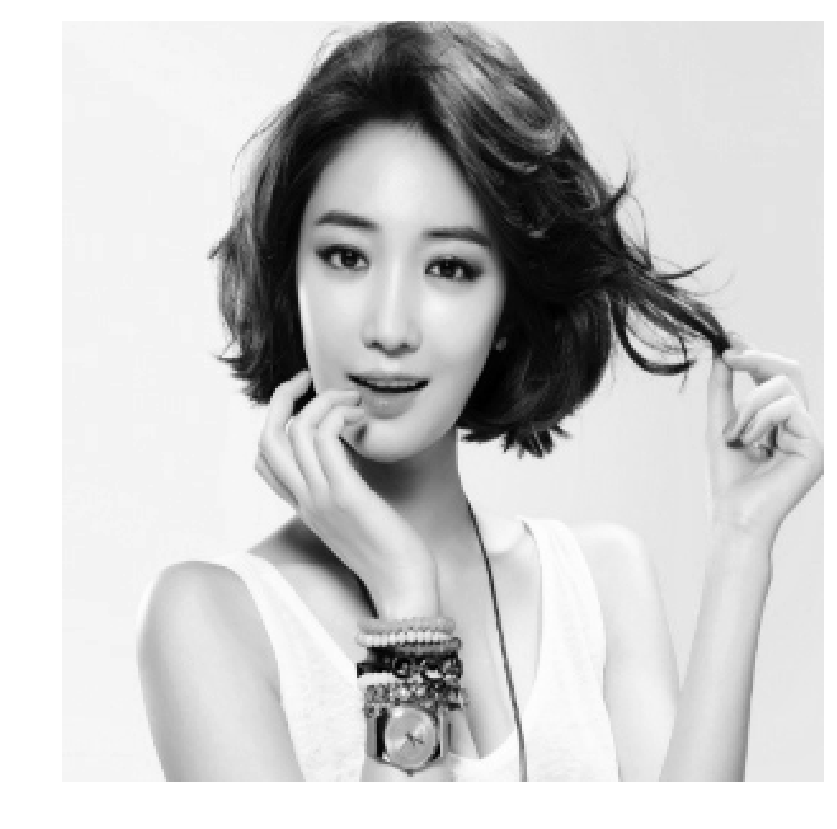

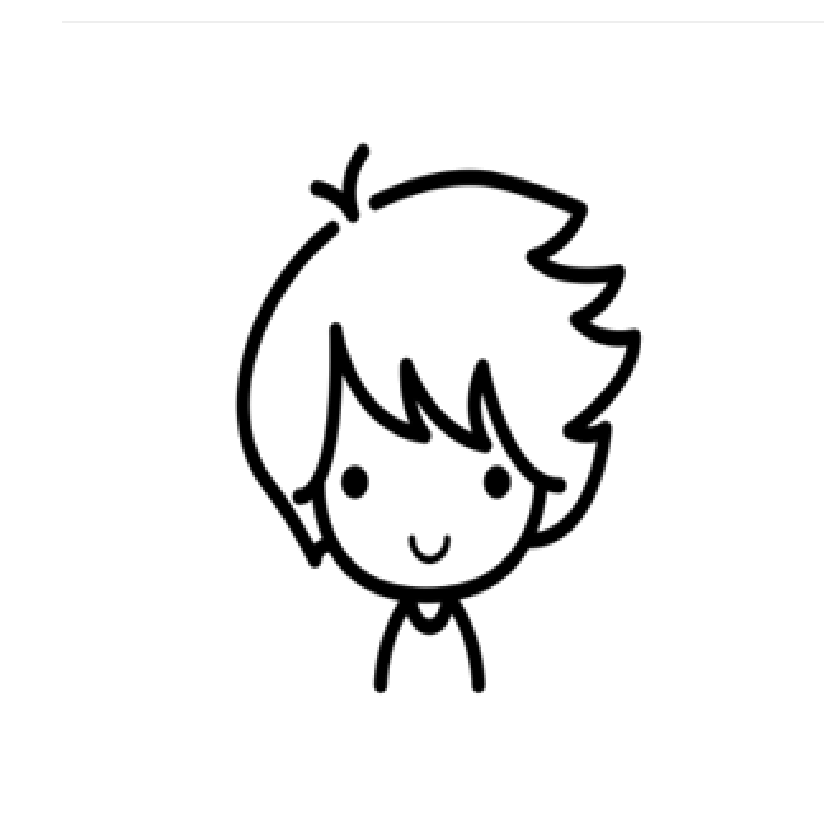

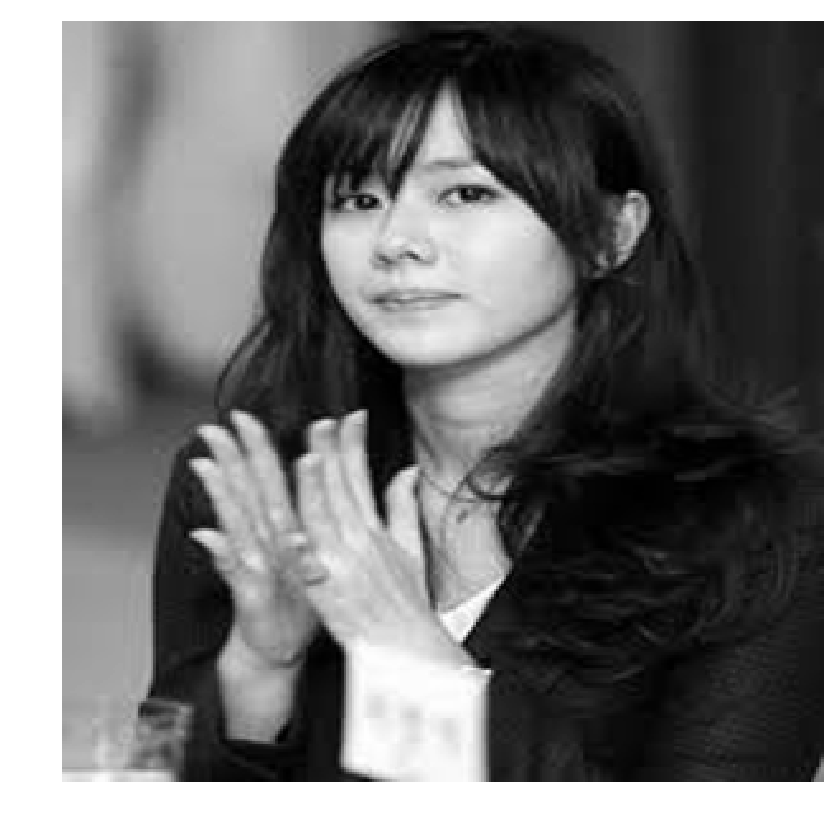

In [15]:
random_display = np.random.randint(0,len(real_img_src), 5) # 중복을 허용해서 5개가 안나올 수 있다. 

pic_resized_img = {}
real_resized_img = {}
for ix, psrc, rsrc in zip(range(len(pic_img_src)), pic_img_src, real_img_src):

    pimg = Image(psrc)
    rimg = Image(rsrc)
    psex = pimg.sex
    rsex = rimg.sex
    
    # adding 10, and keep max 255
    presized = resizing_image(pimg.gray_image_vector).astype(np.float32)
    presized_shape = presized.shape
    presized += np.ones(presized_shape).astype(np.float32) * 10
    presized = np.array([x if x < 255.0 else 255.0 for x in presized.reshape(-1)])
    presized = presized.reshape(presized_shape).astype(np.uint8)
    
    rresized = resizing_image(rimg.gray_image_vector)
    
    pic_resized_img[ix] = (presized, psex)
    real_resized_img[ix] = (rresized, rsex)
    if ix in random_display:
        image_print(presized, color="gray")
        image_print(rresized, color="gray")

### Store it as tfrecord file `train.tfrecod`



In [5]:
# image and sex data parsing 
pic_data = np.array(list(pic_resized_img.values()))
pic_img_data = pic_data[:, 0]
pic_sex_data = pic_data[:, 1]

real_data = np.array(list(real_resized_img.values()))
real_img_data = real_data[:, 0]
real_sex_data = real_data[:, 1]

In [6]:
# pictogram
pic_img_data = np.stack(pic_img_data, axis=0)
pic_img_data = pic_img_data.astype(np.int64)
# real image
real_img_data = np.stack(real_img_data, axis=0)
real_img_data = real_img_data.astype(np.int64)

In [7]:
real_img_data.shape

(34, 300, 300)

In [8]:
def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# Pictogram data to tfrecord
pic_path = "../Dataset/tfrecord/pictogram.tfrecord"
pic_writer = tf.python_io.TFRecordWriter(pic_path)

for img, sex in zip(pic_img_data, pic_sex_data):
    height, width = img.shape
    img = img.tostring()
    example = tf.train.Example(features=tf.train.Features(feature={
            'height': _int64_feature(height),
            'width': _int64_feature(width),
            'sex': _float_feature(sex),
            'gray_img_bytes': _bytes_feature(img)}))
    pic_writer.write(example.SerializeToString())
    
pic_writer.close()

# real image data to tfrecord
real_path = "../Dataset/tfrecord/real_image.tfrecord"
real_writer = tf.python_io.TFRecordWriter(real_path)

for img, sex in zip(real_img_data, real_sex_data):
    height, width = img.shape
    img = img.tostring()
    example = tf.train.Example(features=tf.train.Features(feature={
            'height': _int64_feature(height),
            'width': _int64_feature(width),
            'sex': _float_feature(sex),
            'gray_img_bytes': _bytes_feature(img)}))

    real_writer.write(example.SerializeToString())
    
real_writer.close()

### Test tfrecord file 

['female']


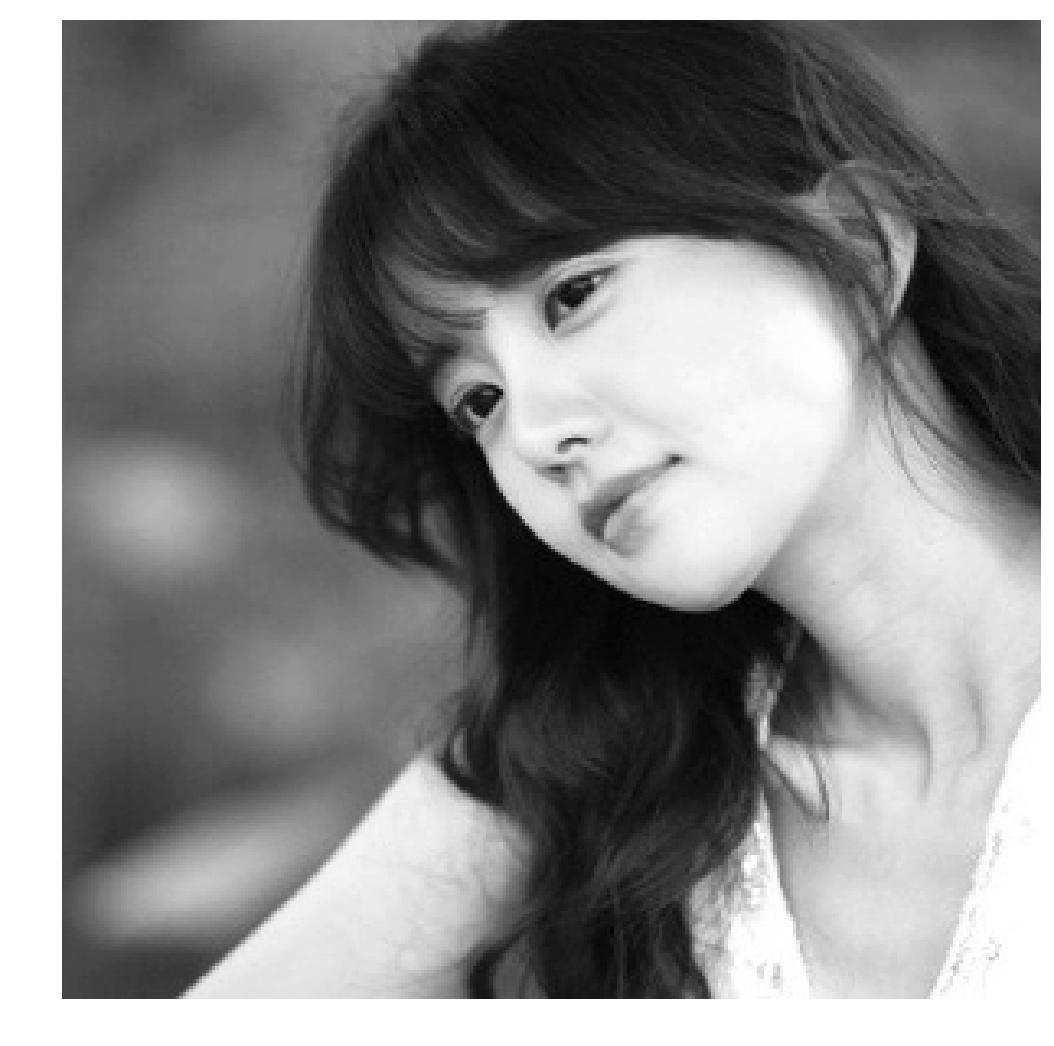

['male']


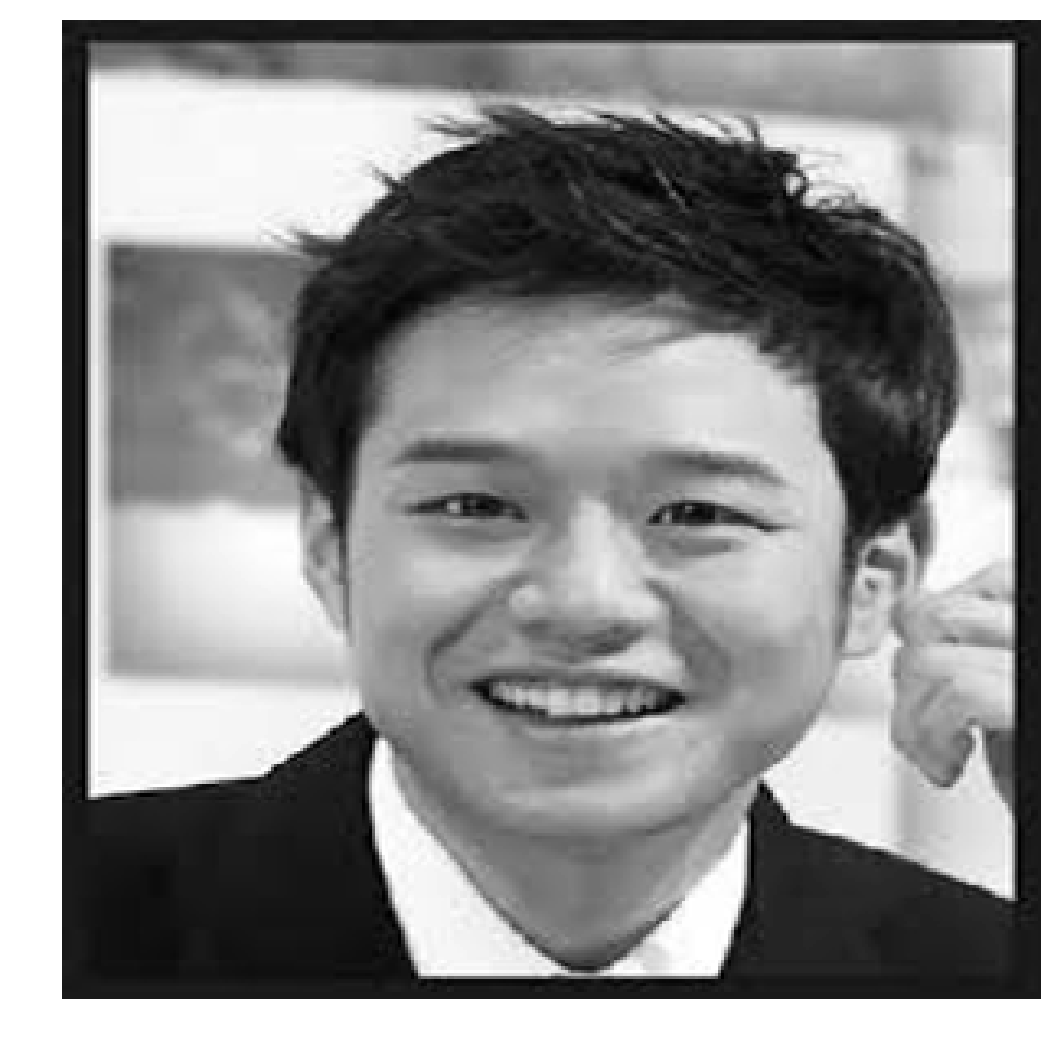

['female']


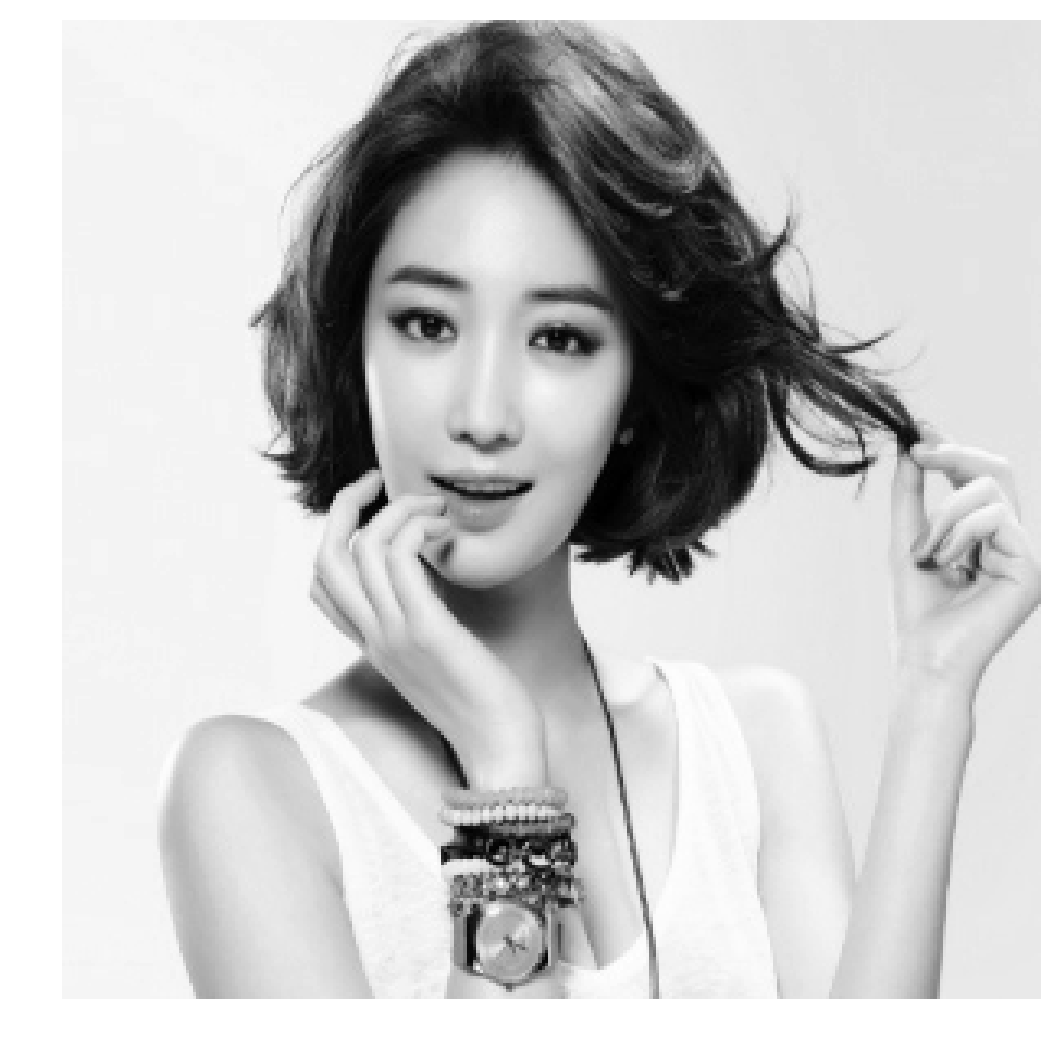

['female']


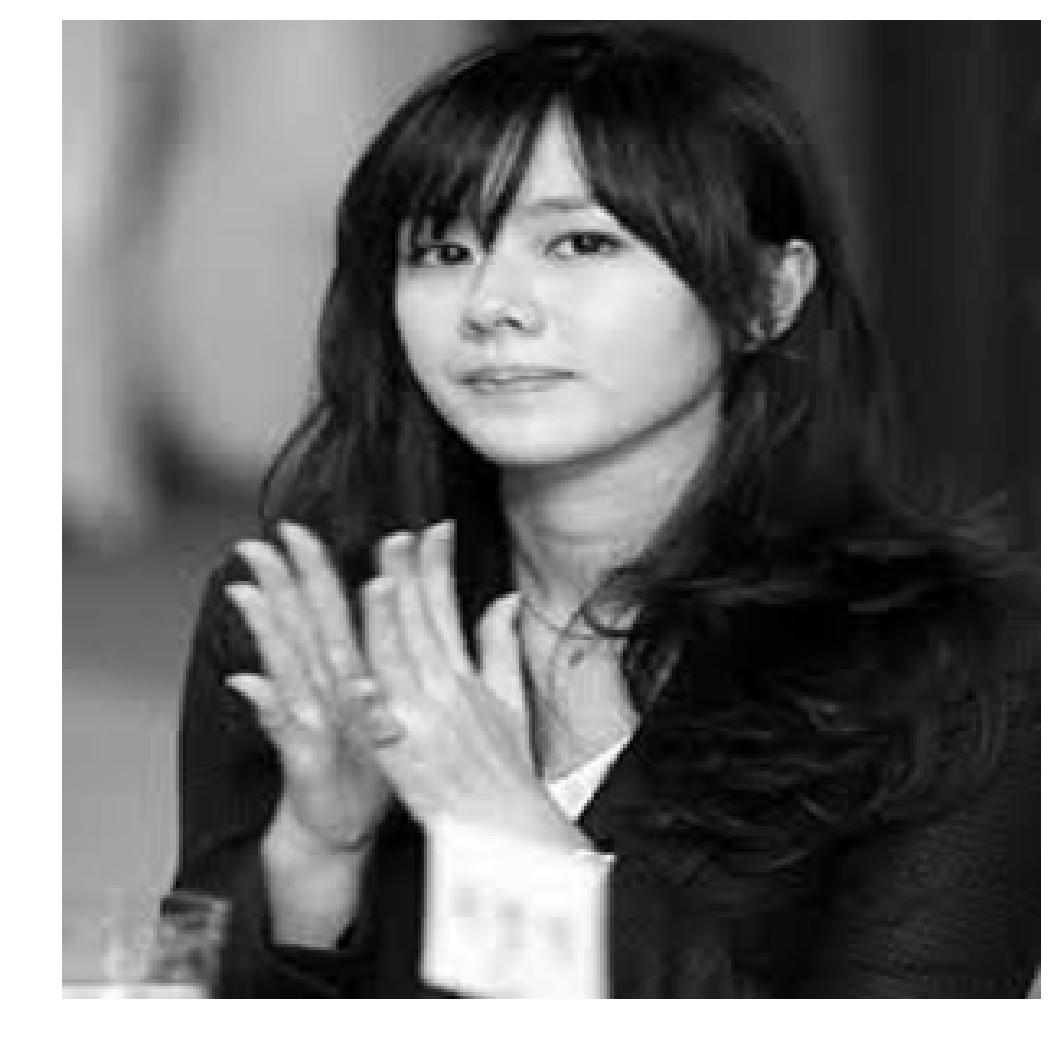

In [25]:
reconstructed_images = []
reconstructed_sexes = []

record_iterator = tf.python_io.tf_record_iterator(path=real_path)
i = 0 
for string_record in record_iterator:
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    height = int(example.features.feature['height']
                                 .int64_list
                                 .value[0])
    
    width = int(example.features.feature['width']
                                .int64_list
                                .value[0])
    
    img_string = (example.features.feature['gray_img_bytes']
                                  .bytes_list
                                  .value[0])
    
    sex = float(example.features.feature['sex']
                                .float_list
                                .value[0])
    
    img_1d = np.frombuffer(img_string, dtype=np.uint8)
    reconstructed_img = img_1d.reshape((height, width, -1))
    # 마지막 axis에 7개의 0이 추가 된다. 
    reconstructed_img = np.amax(reconstructed_img, axis=-1)
    
    reconstructed_images.append(reconstructed_img)
    reconstructed_sexes.append(sex)
    
    if i in random_display:
        print(list(map(lambda x: "male" if x == 0.0 else "female", [sex])))
        plt.figure(figsize=(9,9))
        plt.axis("off")
        plt.imshow(reconstructed_img, cmap="gray")
        plt.show()
    i += 1